# Ensemble Level LSTM Model

In [63]:
from __future__ import print_function
import os
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import os
import datetime
import pickle
from sklearn import datasets, metrics, cross_validation
from urllib import urlretrieve
import matplotlib.pyplot as plt
import random
from itertools import permutations

URL = "https://github.com/anucc/metatone-analysis/raw/master/metadata/"
PICKLE_FILE = "metatone_performances_dataframe.pickle"

if not os.path.exists(PICKLE_FILE):
    urlretrieve(URL + PICKLE_FILE, PICKLE_FILE)

with open(PICKLE_FILE, 'rb') as f:
        metatone_dataset = pickle.load(f)
        
## Int values for Gesture codes.
NUMBER_GESTURES = 9
GESTURE_CODES = {
    'N': 0,
    'FT': 1,
    'ST': 2,
    'FS': 3,
    'FSA': 4,
    'VSS': 5,
    'BS': 6,
    'SS': 7,
    'C': 8}

vocabulary_size = len(GESTURE_CODES)

In [74]:
## Isoloate Individual Performances
improvisations = metatone_dataset[
    (metatone_dataset["performance_type"] == "improvisation") &
    (metatone_dataset["performance_context"] != "demonstration")]
gesture_data = improvisations['gestures']
individual_improvisations = []
for perf in gesture_data.tolist():
    for one_perf in perf.T:
        individual_improvisations.append(one_perf)


## Isolate the Interesting Ensemble Performances
improvisations = metatone_dataset[
    (metatone_dataset["performance_type"] == "improvisation") &
    (metatone_dataset["performance_context"] != "demonstration") &
    (metatone_dataset["number_performers"] == 4)]
gesture_data = improvisations['gestures']
#metatone_dataset["number_performers"]
num_output_performers = 3
ensemble_improvisations = gesture_data.tolist()

def encode_ensemble_gestures(gestures):
    """Encode multiple natural numbers into one"""
    encoded = 0
    for i, g in enumerate(gestures):
        encoded += g * (vocabulary_size ** i)
    return encoded
        
def decode_ensemble_gestures(num_perfs,code):
    gestures = []
    for i in range(num_perfs):
        part = code % (vocabulary_size ** (i+1))
        gestures.append(part / (vocabulary_size ** i))
    return gestures

# Test Gesture Encoding
#b = [0,0,0]
#c = encode_ensemble_gestures(b)
#d = decode_ensemble_gestures(3,c)
#print("Gestures: " + str(b))
#print("Code: " + str(c))
#print("Decoded: " + str(d))

## Setup the epochs
## Each batch is of single gestures as input and tuples of remaining performers as output
def generate_epochs(num_epochs, num_steps, batch_size):
    ## Setup the inputs and label sets
    imp_xs = []
    imp_ys = []
    
    for imp in ensemble_improvisations:
        for i in range(len(imp)-num_steps):
            imp_slice = imp[i:i+num_steps]
            ## TODO: rearrange the ensemble ordering for each window
            ## (more data for training!)
            for j in range(len(imp_slice.T)):
                imp_x = imp_slice.T[j] # just one input gesture
                imp_y = imp_slice.T[np.arange(len(imp_slice.T)) != j] # indexed by player
                for player_perm in permutations(imp_y): # consider all permutations of the players
                    p = np.array(player_perm).T # back to indexed by time slice
                    p = map(encode_ensemble_gestures,p) # encode ensemble state
                    imp_xs.append(imp_x)
                    imp_ys.append(p) # append the ensemble state
    dataset = zip(imp_xs,imp_ys)
    print("Total Training Examples: " + str(len(imp_xs)))
    print("Total Training Labels: " + str(len(imp_ys)))
    epochs = []
    for j in range(num_epochs):
        # shutffle the big list
        np.random.shuffle(dataset)
        dataset_size = len(dataset)
        batches = []
        for i in range(dataset_size / batch_size):
            ## Setup the batches
            batch = dataset[i*batch_size:(i+1)*batch_size]
            bx,by = zip(*batch)
            batches.append((np.array(bx),np.array(by)))
        epochs.append(batches)
    return epochs


#t = ensemble_improvisations[0]
#len(t[0])
#t.T[np.arange(len(t.T))!=0]
#np.arange(len(t))!=3

# Test 
a = generate_epochs(2,10,20)
e1 = a[0]
#e2 = a[1]
print(e1[0][0])
#print(e1[0][1])
y1 = e1[0][1][15]
print(y1)

#np.apply_along_(encode_ensemble_gestures,y1)
#encode_ensemble_gestures,y1,0)



Total Training Examples: 449472
Total Training Labels: 449472
[[4 4 4 4 4 3 4 4 4 4]
 [0 2 2 2 2 2 2 2 2 0]
 [2 2 2 2 2 2 2 2 2 2]
 [4 4 4 4 4 2 2 0 0 0]
 [2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2]
 [3 3 1 1 1 1 1 2 2 2]
 [4 0 2 7 3 3 8 6 5 2]
 [0 0 0 0 0 0 0 0 0 0]
 [8 8 8 8 8 8 8 6 6 6]
 [2 2 2 2 3 3 4 4 7 7]
 [4 2 2 3 4 4 4 3 3 4]
 [4 4 4 4 4 8 8 7 7 7]
 [2 2 2 2 2 2 2 2 2 2]
 [4 4 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [4 3 3 3 3 3 3 3 3 0]
 [2 2 2 2 2 2 2 2 2 2]
 [4 4 4 4 4 4 4 4 6 6]
 [0 0 0 0 0 0 0 0 0 0]]
[567 567 567 585 594 576 576 576 576 582]


In [75]:
def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

## Training Network
## Hyperparameters for training
num_nodes = 64
num_classes = vocabulary_size
num_output_classes = vocabulary_size ** num_output_performers
batch_size = 64
num_steps = 120
num_layers = 3
learning_rate = 1e-4

#def load_graph():
#graph = tf.Graph()
reset_graph()
graph = tf.get_default_graph()
with graph.as_default():
    x = tf.placeholder(tf.int32,[batch_size,num_steps], name='input_placeholder')
    y = tf.placeholder(tf.int32,[batch_size,num_steps], name='labels_placeholder')
    embeddings = tf.get_variable('embedding_matrix', [num_classes, num_nodes])
    out_embedding = tf.get_variable('out_emedding_matrix',[num_output_classes,num_nodes])
    rnn_inputs = tf.nn.embedding_lookup(embeddings,x)
    
    # Define the network
    cell = tf.nn.rnn_cell.LSTMCell(num_nodes,state_is_tuple=True)
    cell = tf.nn.rnn_cell.MultiRNNCell([cell] * num_layers, state_is_tuple=True)
    init_state = cell.zero_state(batch_size,tf.float32)
    rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, initial_state=init_state)

    with tf.variable_scope('softmax'):
        W = tf.get_variable('W',[num_nodes,num_output_classes])
        b = tf.get_variable('b',[num_output_classes], initializer=tf.constant_initializer(0.0))
    
    rnn_outputs = tf.reshape(rnn_outputs,[-1,num_nodes])
    y_reshaped = tf.reshape(y,[-1])
    logits = tf.matmul(rnn_outputs, W) + b
    predictions = tf.nn.softmax(logits)

    total_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, y_reshaped))
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)
    saver = tf.train.Saver()
    print("Graph Specs:")
    print("Inputs: " + str(rnn_inputs))
    print("Outputs: " + str(rnn_outputs))
    print("Logits: " + str(logits))
    print("Predictions: " + str(predictions))
        
        
## Training Network
## Hyperparameters for training
#num_steps = 120

#load_graph()


Graph Specs:
Inputs: Tensor("embedding_lookup:0", shape=(64, 120, 64), dtype=float32)
Outputs: Tensor("Reshape:0", shape=(7680, 64), dtype=float32)
Logits: Tensor("add:0", shape=(7680, 729), dtype=float32)
Predictions: Tensor("Softmax:0", shape=(7680, 729), dtype=float32)


### Training

In [ ]:
num_epochs = 100
tf.set_random_seed(2345)

model_name = "ensemble-lstm-model-" + str(num_epochs) +  "-epochs.tfsave"
print("Going to train: " + model_name)

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    training_losses = []
    print("Starting Training")
    for i, epoch in enumerate(generate_epochs(num_epochs, num_steps, batch_size)):
        ## Setup for each epoch
        training_loss = 0
        steps = 0
        training_state = None
        print("Starting Epoch " + str(i) + " of " + str(num_epochs))
        for batch_data, batch_labels in epoch:
            #print(batch_data.shape)
            #print(batch_labels.shape)
            ## Setup for each batch
            feed = {x:batch_data, y:batch_labels}
            if training_state is not None:
                feed[init_state] = training_state
            #print(str(feed))
            ## Evaluate the train step
            training_loss_current, training_state, _ = sess.run([total_loss,final_state,train_step],feed_dict=feed)
            steps += 1
            training_loss += training_loss_current
            if (steps % 500 == 0): 
                print("Trained batch: " + str(steps) + " of " + str(len(epoch)) + " loss was: " + str(training_loss_current))
        print("Trained Epoch " + str(i) + " of " + str(num_epochs))
        training_losses.append(training_loss/steps)
    ## Save the results
    print("Finished Training, Saving Model.")
    saver.save(sess,model_name)
    print("Model was saved.")
    #tf.train.Saver()

Going to train: ensemble-lstm-model-100-epochs.tfsave
Starting Training
Total Training Examples: 362352
Total Training Labels: 362352


Epoch vs Training Losses


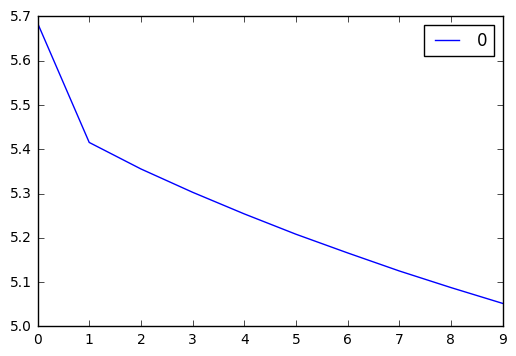

In [43]:
## Plot Training Results:
a = pd.DataFrame(training_losses)
print("Epoch vs Training Losses")
plt.show(a.plot())

### Generating

In [47]:
## Evaluating Network

batch_size = 1
num_steps = 1

## Reload the graph
## Training Network
reset_graph()
graph = tf.get_default_graph()
with graph.as_default():
    x = tf.placeholder(tf.int32,[batch_size,num_steps], name='input_placeholder')
    y = tf.placeholder(tf.int32,[batch_size,num_steps], name='labels_placeholder')
    embeddings = tf.get_variable('embedding_matrix', [num_classes, num_nodes])
    out_embedding = tf.get_variable('out_emedding_matrix',[num_output_classes,num_nodes])
    rnn_inputs = tf.nn.embedding_lookup(embeddings,x)
    
    # Define the network
    cell = tf.nn.rnn_cell.LSTMCell(num_nodes,state_is_tuple=True)
    cell = tf.nn.rnn_cell.MultiRNNCell([cell] * num_layers, state_is_tuple=True)
    init_state = cell.zero_state(batch_size,tf.float32)
    rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, initial_state=init_state)

    with tf.variable_scope('softmax'):
        W = tf.get_variable('W',[num_nodes,num_output_classes])
        b = tf.get_variable('b',[num_output_classes], initializer=tf.constant_initializer(0.0))
    
    rnn_outputs = tf.reshape(rnn_outputs,[-1,num_nodes])
    y_reshaped = tf.reshape(y,[-1])
    logits = tf.matmul(rnn_outputs, W) + b
    predictions = tf.nn.softmax(logits)

    total_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, y_reshaped))
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)
    saver = tf.train.Saver()
    print("Graph Specs:")
    print("Inputs: " + str(rnn_inputs))
    print("Outputs: " + str(rnn_outputs))
    print("Logits: " + str(logits))
    print("Predictions: " + str(predictions))


Graph Specs:
Inputs: Tensor("embedding_lookup:0", shape=(1, 1, 64), dtype=float32)
Outputs: Tensor("Reshape:0", shape=(1, 64), dtype=float32)
Logits: Tensor("add:0", shape=(1, 729), dtype=float32)
Predictions: Tensor("Softmax:0", shape=(1, 729), dtype=float32)


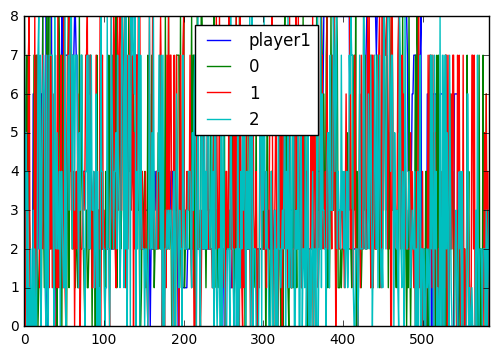

In [62]:
num_gen_steps = 443
num_performances = 1
generated_performance = pd.DataFrame()
player_one = random.choice(individual_improvisations)
generated_performance["player1"] = player_one
player_one = player_one.tolist()

with tf.Session() as sess:
    # possibly restore all variables
    sess.run(tf.initialize_all_variables())
    saver.restore(sess, "./"+model_name)
    
    # start generating output
    state = None
    output_perf = []
    
    for current_step in player_one:
        if state is not None:
            feed_dict = {x: [[current_step]], init_state: state}
        else:
            feed_dict = {x: [[current_step]]}
        preds,state = sess.run([predictions,final_state],feed_dict=feed_dict)
        current_step = np.random.choice(num_output_classes,1,p=np.squeeze(preds))[0] # choose the output step
        output_perf.append(current_step)
        

out = np.array([decode_ensemble_gestures(num_output_performers,i) for i in output_perf])
len(out.T)

for i, seq in enumerate(out.T):
    generated_performance[i] = seq

#output_perf = pd.DataFrame({j:output_perf})
#generated_performance[j] = output_perf[j]

#generated_performance.to_csv("100epoch-120step-performances")   
plt.show(generated_performance.plot())

In [70]:
print(len(player_one))
print(len(output_perf))

print(str(out.T))

for p in permutations([0,1,2]):
    print(p)


585
585
[[8 4 5 ..., 0 0 0]
 [4 0 5 ..., 4 0 0]
 [8 3 5 ..., 2 3 0]]
(0, 1, 2)
(0, 2, 1)
(1, 0, 2)
(1, 2, 0)
(2, 0, 1)
(2, 1, 0)
